In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from zipfile import ZipFile
from PIL import Image,ImageEnhance
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt


/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
path = '/kaggle/input/dogs-vs-cats/'

with ZipFile('' + path + 'train.zip', 'r') as train_zip:
    train_zip.extractall('./')

with ZipFile('' + path + 'test1.zip', 'r') as test_zip:
    test_zip.extractall('./')

In [3]:
img_size = 256
batch_size=16
epochs=10

# Data Generator

In [4]:
path_train = './train/'
train_data_name = os.listdir(path_train)
train_data_lable = []#np.zeros((np.size(train_data_name),1),dtype="int")

for i in range(0,np.size(train_data_name)):
 if train_data_name[i].rsplit('.')[0] == 'cat':
    train_data_lable.append("cat")
 else:
    train_data_lable.append("dog")

train_data_df = pd.DataFrame({
    'train_data_name': train_data_name,
    'train_data_lable': train_data_lable
})
#train_data_df['train_data_lable']=train_data_df['train_data_lable'].astype('str')
train_data_df.head()

,train_data_name,train_data_lable
0,cat.5660.jpg,cat
1,dog.7997.jpg,dog
2,cat.10679.jpg,cat
3,cat.6004.jpg,cat
4,cat.7316.jpg,cat


In [5]:
path_test = './test1/'
test_data_name = os.listdir(path_test)
test_ID = []
for i in range(0,np.size(test_data_name)):
    test_ID.append(test_data_name[i].rsplit('.')[0])
test_data_df = pd.DataFrame({
    'test_data_name': test_data_name
})
test_data_df.head()

,test_data_name
0,3801.jpg
1,10551.jpg
2,3270.jpg
3,1660.jpg
4,9153.jpg


In [6]:
from sklearn.model_selection import train_test_split

train_valid_df, test_df = train_test_split(train_data_df, test_size = 0.04)
train_df, valid_df = train_test_split(train_valid_df, test_size = 0.2)

In [7]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                              #rescale=1./255,
                                                              #shear_range=0.2,
                                                              #zoom_range=0.2,
                                                              horizontal_flip=True,
                                                              width_shift_range=0.2,
                                                              height_shift_range=0.2,
                                                              fill_mode='nearest',
                                                              preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    path_train, 
                                                    x_col='train_data_name',
                                                    y_col='train_data_lable',
                                                    class_mode='binary',
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size
)

Found 19200 validated image filenames belonging to 2 classes.


In [8]:
valid_datagen=tf.keras.preprocessing.image.ImageDataGenerator(#rescale=1./255,
                                                              preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)
valid_generator = train_datagen.flow_from_dataframe(
    valid_df,
    path_train, 
    x_col='train_data_name',
    y_col='train_data_lable',
    class_mode='binary',
    target_size=(img_size, img_size),
    batch_size=batch_size
)

Found 4800 validated image filenames belonging to 2 classes.


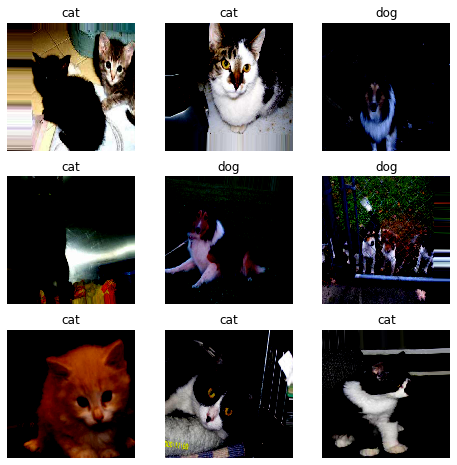

In [9]:
class_map = {v: k for k, v in train_generator.class_indices.items()}
plt.figure(figsize=(8, 8))
batch = next(train_generator)
for x in range(0,9):
    plt.subplot(3, 3, x+1)
    plt.imshow(batch[0][x], interpolation='nearest')
    item_label = batch[1][x]
    item_label = class_map[int(item_label)]
    plt.title(item_label)
    plt.axis('off')

plt.show()

# ResNet

In [10]:
resNet = tf.keras.applications.ResNet50V2(weights = 'imagenet',include_top = False,input_shape = (img_size,img_size, 3))

tf.keras.trainable=False # Freeze layers
resNet_model = tf.keras.Sequential([
        resNet,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation = 'relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')])
resNet_model.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 157,784,577
Trainable params: 157,739,137
Non-trainable params: 45,440
_________________________________________________________________


In [11]:
loss_function='binary_crossentropy'
filepath='./'
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=0,mode='min')
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath + 'Resnet50_best.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
callback=[EarlyStopping,ReduceLROnPlateau,ModelCheckpoint]

In [12]:
resNet_model.compile(optimizer=optimizer,loss=loss_function,metrics=['accuracy'])

In [13]:
resnet_his = resNet_model.fit(train_generator,batch_size=batch_size,epochs=15,validation_data=valid_generator,steps_per_epoch=15,validation_steps=15,callbacks=callback)

Epoch 1/15
15/15 [==============================] - 17s 675ms/step - loss: 1.5878 - accuracy: 0.6376 - val_loss: 0.5493 - val_accuracy: 0.9583

Epoch 00001: val_loss improved from inf to 0.54935, saving model to ./Resnet50_best.h5
Epoch 2/15
15/15 [==============================] - 9s 589ms/step - loss: 0.4542 - accuracy: 0.9077 - val_loss: 0.1988 - val_accuracy: 0.9708

Epoch 00002: val_loss improved from 0.54935 to 0.19879, saving model to ./Resnet50_best.h5
Epoch 3/15
15/15 [==============================] - 9s 624ms/step - loss: 0.4815 - accuracy: 0.9409 - val_loss: 0.8545 - val_accuracy: 0.9375

Epoch 00003: val_loss did not improve from 0.19879
Epoch 4/15
15/15 [==============================] - 8s 573ms/step - loss: 1.4920 - accuracy: 0.8493 - val_loss: 1.0162 - val_accuracy: 0.9250

Epoch 00004: val_loss did not improve from 0.19879
Epoch 5/15
15/15 [==============================] - 9s 584ms/step - loss: 0.4027 - accuracy: 0.9335 - val_loss: 0.8261 - val_accuracy: 0.9375

Epoc

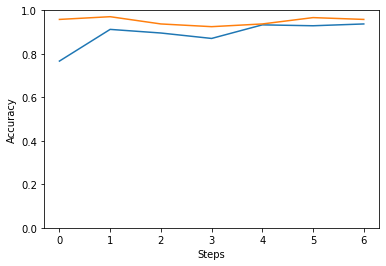

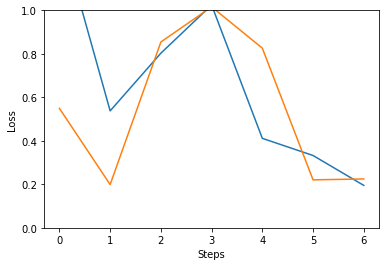

In [14]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Steps")
plt.ylim([0,1])
plt.plot(resnet_his.history["accuracy"])
plt.plot(resnet_his.history["val_accuracy"])
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Steps")
plt.ylim([0,1])
plt.plot(resnet_his.history['loss'],) 
plt.plot(resnet_his.history['val_loss'],)



In [15]:
test_aug_map = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

test_df = test_aug_map.flow_from_dataframe(
    test_df, path_train,
    x_col='train_data_name',
    y_col='train_data_lable',
    class_mode = 'binary',
    target_size = (img_size, img_size))

Found 1000 validated image filenames belonging to 2 classes.


In [16]:
test_aug_map = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

test_data = test_aug_map.flow_from_dataframe(
    test_data_df, path_test,
    x_col='test_data_name',
    y_col=None,
    class_mode = None,
    target_size = (img_size, img_size),
    shuffle = False)


Found 12500 validated image filenames.


In [17]:
resNet_model.evaluate(test_df)

32/32 [==============================] - 5s 135ms/step - loss: 0.1986 - accuracy: 0.9770


[0.19858142733573914, 0.9769999980926514]

In [18]:
test_data.reset()
test_label = resNet_model.predict(test_data,verbose=1)

391/391 [==============================] - 51s 129ms/step


In [19]:
test_label_c = [1 if l[0] > 0.5 else 0 for l in test_label]

In [20]:
test_label_show = []
for l in test_label:
    if l[0] < 0.5:
        test_label_show.append('cat')
    else:
        test_label_show.append('dog')

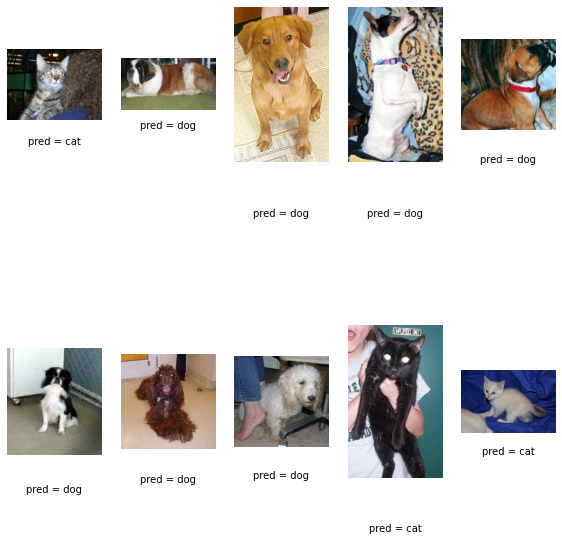

In [21]:
n_to_show = 10
indices = np.random.choice(range(len(test_ID)), n_to_show)
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
for i, idx in enumerate(indices):
    img = Image.open(path_test+test_ID[idx]+".jpg")
    a = 1
    b=i+1
    if i > 4:
        a=2
        b = b-5
    ax = fig.add_subplot(a, n_to_show, b)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(test_label_show[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)

In [22]:
output =pd.DataFrame({'id': test_ID,'label': test_label_c})
output.head
output.to_csv('submission.csv', index=False)